## CHAPTER 2

problems from chapter 1:

    -the model is learning only to predict bearish positions somehow, regardless diversified dataset.
    -the model is overfitted, it is making predictions only in 10 months out of 40

#### Goals for this chapter:
    -create one function to calculate the mdoel performance on many fields
    -Apply Conv1D layers

#### 1.1 Import libriaries and the model

Libriaries

In [52]:
import matplotlib
import numpy as np
import pandas as pd
import itertools
import sklearn
import keras
import time
import shap
import datetime

from keras.models import Sequential
from keras.layers import Dense, Dropout, CuDNNLSTM, Conv1D
from matplotlib import pyplot as plt
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_finance import candlestick_ohlc
import seaborn as sns

print('Numpy version: ' + np.__version__)
print('Pandas version: ' + pd.__version__)
print('Matplotlib version: ' + matplotlib.__version__)
print('Sklearn version: ' + sklearn.__version__)
print('Keras version: ' + keras.__version__)

Numpy version: 1.16.4
Pandas version: 0.24.2
Matplotlib version: 3.1.0
Sklearn version: 0.21.2
Keras version: 2.2.4


model

In [2]:
# model name: predict_candlestick_1.8.h5
from keras.models import load_model
model = load_model('predict_candlestick_1.8.h5')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_15 (CuDNNLSTM)    (None, None, 12)          864       
_________________________________________________________________
dropout_11 (Dropout)         (None, None, 12)          0         
_________________________________________________________________
cu_dnnlstm_16 (CuDNNLSTM)    (None, None, 24)          3648      
_________________________________________________________________
dropout_12 (Dropout)         (None, None, 24)          0         
_________________________________________________________________
cu_dnnlstm_17 (CuDNNLSTM)    (None, None, 24)          4800      
_________________________________________________________________
dropout_13 (Dropout)         (None, None, 24)          0         
_________________________________________________________________
cu_dnnlstm_18 (CuDNNLSTM)    (None, None, 24)         

#### 1.2 import feature engineering functions and dataset

Function to plot candlestick charts

In [3]:
def graph_data_ohlc(dataset):
    fig = plt.figure()
    ax1 = plt.subplot2grid((1,1), (0,0))
    closep=dataset[:,[3]]
    highp=dataset[:,[1]]
    lowp=dataset[:,[2]]
    openp=dataset[:,[0]]
    date=range(len(closep))
    
    x = 0
    y = len(date)
    ohlc = []
    while x < y:
        append_me = date[x], openp[x], highp[x], lowp[x], closep[x]
        ohlc.append(append_me)
        x+=1
    candlestick_ohlc(ax1, ohlc, width=0.4, colorup='#77d879', colordown='#db3f3f')
    for label in ax1.xaxis.get_ticklabels():
        label.set_rotation(45)
    ax1.xaxis.set_major_locator(mticker.MaxNLocator(10))
    ax1.grid(True)
    plt.xlabel('Candle')
    plt.ylabel('Price')
    plt.title('Candlestick sample representation')
    
    plt.subplots_adjust(left=0.09, bottom=0.20, right=0.94, top=0.90, wspace=0.2, hspace=0)
    plt.show()

Function to convert OHLC data to candlestick data in form of pip values

In [4]:
def ohlc_to_candlestick(conversion_array):
    candlestick_data = [0,0,0,0]
    
    if conversion_array[4]>conversion_array[1]:
        candle_type=1
        wicks_up=conversion_array[2]-conversion_array[4]
        wicks_down=conversion_array[3]-conversion_array[1]
        body_size=conversion_array[4]-conversion_array[1]
        
    else:
        candle_type=0
        wicks_up=conversion_array[2]-conversion_array[1]
        wicks_down=conversion_array[3]-conversion_array[4]
        body_size=conversion_array[2]-conversion_array[4]

    
    if wicks_up < 0:wicks_up=wicks_up*(-1)
    if wicks_down < 0:wicks_down=wicks_down*(-1)
    if body_size < 0:body_size=body_size*(-1)
    candlestick_data[0]=candle_type
    candlestick_data[1]=round(round(wicks_up,5)*10000,2)
    candlestick_data[2]=round(round(wicks_down,5)*10000,2)
    candlestick_data[3]=round(round(body_size,5)*10000,2)
    
    return candlestick_data

Function to generate time series sequence

In [191]:
def my_generator_candle_X_Y(data,lookback,MinMax = False,Multi=False):
    if MinMax==True:scaler = preprocessing.MinMaxScaler()
    first_row = 0
    arr = np.empty((0,lookback,4))
    arr3 = np.empty((0,lookback,5))
    Y_list = []
    Y_dates_list = []
    for a in range(len(data)-lookback):
        temp_list = []
        temp_list_raw = []
        for candle in data[first_row:first_row+lookback]:
            converted_data = ohlc_to_candlestick(candle)
            temp_list.append(converted_data)
            temp_list_raw.append(candle)
        temp_list3 = [np.asarray(temp_list)]
        templist4 = np.asarray(temp_list3)
        
        if MinMax==True:
            templist99 = scaler.fit_transform(templist4[0])
            arr = np.append(arr, [templist99], axis=0)
        else:    
            arr = np.append(arr, templist4, axis=0)
        
        temp_list7 = [np.asarray(temp_list_raw)]
        templist8 = np.asarray(temp_list7)
        arr3 = np.append(arr3, templist8, axis=0)

        converted_data_prediction = ohlc_to_candlestick(data[first_row+lookback])
        Prediction = converted_data_prediction[0]
        if Multi==True:
            if Prediction== 1: Prediction=[1,0]
            if Prediction== 0: Prediction=[0,1]
            Y_list.append(np.asarray(Prediction))
        if Multi==False:  
            Y_list.append(Prediction)
        
        
        Y_dates_list.append(data[first_row+lookback][0])
        
        first_row=first_row+1

    arr2 = np.asarray(Y_list)
    arr4 = np.asarray(Y_dates_list)
    
    return arr,arr2,arr3,arr4

Load the EURUSD 2003 - 2019 , 1h candle sticks dataset from ducascopy.com

In [6]:
EURUSD_dataset = pd.read_csv('Hour/EURUSD.csv')
del EURUSD_dataset['Volume']
X,Y, X_raw, Y_dates = my_generator_candle_X_Y(EURUSD_dataset.values,3,MinMax=False)

Make the model predictions

In [8]:
raw_predictions = model.predict(X)

#### 1.4 - Performance function

##### This function should contain:
    - Profitability with % (WON% & LOSS %)
    - Number of Bullish & Bearish predictions
    - Consequative win and looses in a row 
    - Bar chart with total number of trades per each month
    - Heatmap with weekday vs the hours (spot the high activity hours during the week)
    

Let's divide it to small functions that will perform only one action and the we will create one function to merge them all.

#### 1.4.1 - Profitability with % (WON% & LOSS %)

In [9]:
def get_win_loss_stat(alpha_distance,raw_predictions, target_predictions):
    counter = 0
    won = 0
    lost = 0
    for a in raw_predictions:
        if a > (1-alpha_distance) or a < alpha_distance :
            if (a > (1-alpha_distance) and target_predictions[counter] == 1) or (a < alpha_distance and target_predictions[counter] == 0):
                won=won+1
            else:
                lost=lost+1
        counter=counter+1
    return [won,lost]

In [10]:
won,lost = get_win_loss_stat(0.4,raw_predictions, Y)
print('Won: ' + str(won) + ' Lost: ' + str(lost) + ' Total:' + str(won+lost))

Won: 673 Lost: 345 Total:1018


#### 1.4.2 - Number of Bullish & Bearish predictions

In [11]:
def get_bullish_bearish_stat(alpha_distance,raw_predictions):
    bullish_count=0
    bearish_count=0
    for pred in raw_predictions:
        if pred < alpha_distance: bearish_count=bearish_count+1
        if pred > (1-alpha_distance): bullish_count=bullish_count+1
    return [bullish_count,bearish_count]

In [12]:
bullish,bearish = get_bullish_bearish_stat(0.4,raw_predictions)
print('Bullish: ' + str(bullish) + ' Bearish: ' + str(bearish) + ' Total:' + str(bullish+bearish))

Bullish: 0 Bearish: 1018 Total:1018


#### 1.4.3 - Consequative win and looses in a row 

In [13]:
def get_consequitive_trades_stat(alpha_distance,raw_predictions,target_predictions):
    counter = 0
    ConsequtiveStats = []
    for a in raw_predictions:
            if a > (1-alpha_distance) or a < alpha_distance :
                if (a > (1-alpha_distance) and target_predictions[counter] == 1) or (a < alpha_distance and target_predictions[counter] == 0):
                    ConsequtiveStats.append(1)
                else:
                    ConsequtiveStats.append(0)
            counter=counter+1
    z = [(x[0], len(list(x[1]))) for x in itertools.groupby(ConsequtiveStats)]    
    MaxLost = 0
    MaxWon = 0
    for a in z:
        if a[0]==0:
            if a[1] > MaxLost: MaxLost = a[1]
        else:
            if a[1] > MaxWon: MaxWon = a[1]     
    return [MaxWon,MaxLost]

In [14]:
max_con_wins,max_con_lost = get_consequitive_trades_stat(0.4,raw_predictions,Y)
print('Max consequitive wins: ' + str(max_con_wins) + ' Max consequitive looses: ' + str(max_con_lost))

Max consequitive wins: 28 Max consequitive looses: 6


#### 1.4.4 - Bar chart with total number of trades per each month

In [15]:
def get_trades_per_period_stat(alpha_distance,raw_predictions,timeperiod):
    output = []
    templist=[]
    addval=0
    counter=0
    for pre in raw_predictions:
        if counter % timeperiod == 0 and counter != 0 :
            output.append(sum(templist.copy()))
            templist=[]
        if pre < alpha_distance: addval = 1    
        elif pre > (1-alpha_distance): addval = 1
        else:
            addval = 0
        templist.append(addval)
        counter=counter+1
    return output

In [16]:
# Hours in: [Day:24], [Week:120], [Month:504]
trades_per_month = get_trades_per_period_stat(0.4,raw_predictions,504)
months_with_trades = len(list(filter(lambda trades_per_month: trades_per_month > 0, trades_per_month)))
months_with_zero_trades = len(list(filter(lambda trades_per_month: trades_per_month == 0, trades_per_month)))
print('Months with trades: ' + str(months_with_trades) + ' ,Months with no trades: ' + str(months_with_zero_trades))
print('Test period in months: ' +  str(months_with_trades+months_with_zero_trades))
print('Test period in years: ' +  str(round((months_with_trades+months_with_zero_trades)/12,1)))

Months with trades: 172 ,Months with no trades: 28
Test period in months: 200
Test period in years: 16.7


#### 1.4.5 - Heatmap with weekday vs the hours (spot the high activity hours during the week)

In [17]:
def get_week_activity(alpha_distance,raw_predictions,date_values):  
    Monday_ls = [0] * 24
    Tuesday_ls = [0] * 24
    Wendsday_ls = [0] * 24
    Thursday_ls = [0] * 24
    Friday_ls = [0] * 24

    counter = 0

    for a in raw_predictions:
        if a > (1-alpha_distance) or a < alpha_distance :
            raw_date_converted = datetime.datetime.strptime(date_values[counter], '%d.%m.%Y %H:%M:%S.000')
            week_day = raw_date_converted.weekday()
            hour = raw_date_converted.hour         
            if week_day==0: Monday_ls[hour-1]=Monday_ls[hour-1]+1
            if week_day==1: Tuesday_ls[hour-1]=Tuesday_ls[hour-1]+1
            if week_day==2: Wendsday_ls[hour-1]=Wendsday_ls[hour-1]+1
            if week_day==3: Thursday_ls[hour-1]=Thursday_ls[hour-1]+1
            if week_day==4: Friday_ls[hour-1]=Friday_ls[hour-1]+1
        counter=counter+1
        
    return [Monday_ls,Tuesday_ls,Wendsday_ls,Thursday_ls,Friday_ls]   

In [18]:
week_activity=get_week_activity(0.4,raw_predictions,Y_dates)
print('Trades on Monday: ' + str(sum(week_activity[0])))
print('Trades on Tuesday: ' + str(sum(week_activity[1])))
print('Trades on Wendsday: ' + str(sum(week_activity[2])))
print('Trades on Thursday: ' + str(sum(week_activity[3])))
print('Trades on Friday: ' + str(sum(week_activity[4])))
print('Total Trades: ' + str(sum(week_activity[0])+sum(week_activity[1])+sum(week_activity[2])+sum(week_activity[3])+sum(week_activity[4])))

Trades on Monday: 249
Trades on Tuesday: 238
Trades on Wendsday: 171
Trades on Thursday: 180
Trades on Friday: 157
Total Trades: 995


#### 1.5 - Mergin stats functions in to on big function.

To fully test the function, we need the training history data, so to get this, we will create our model from scratch and train it

Load the dataset

In [19]:
EURUSD_dataset = pd.read_csv('Hour/EURUSD.csv')
del EURUSD_dataset['Volume']
X,Y, X_raw, Y_dates = my_generator_candle_X_Y(EURUSD_dataset.values,3,MinMax=False)

KeyboardInterrupt: 

Split the dataset

In [22]:
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X, Y, test_size=0.5)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

X_train_raw, X_val_and_test_raw,Y_dates_train,Y_dates_val_and_test= train_test_split(X_raw,Y_dates ,test_size=0.5)
X_val_raw, X_test_raw,Y_dates_val,Y_dates_test = train_test_split(X_val_and_test_raw,Y_dates_val_and_test, test_size=0.5)

Create model

In [23]:
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()

model.add(layers.CuDNNLSTM(units = 12,return_sequences=True, input_shape = (None, X.shape[-1])))
model.add(Dropout(0.3))
model.add(layers.CuDNNLSTM(units = 24,return_sequences=True,))
model.add(Dropout(0.3))
model.add(layers.CuDNNLSTM(units = 24,return_sequences=True))
model.add(Dropout(0.3))
model.add(layers.CuDNNLSTM(units = 24,return_sequences=True))
model.add(Dropout(0.2))
model.add(layers.CuDNNLSTM(units = 12,return_sequences=True))
model.add(Dropout(0.2))
model.add(layers.CuDNNLSTM(units = 6))

model.add(layers.Dense(units = 1,activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

Train the model and pass all the training data in to the 'history' variable

In [25]:
history = model.fit(X_train, Y_train,batch_size=500, epochs=25,validation_data=(X_val, Y_val))


Train on 50578 samples, validate on 25289 samples
Epoch 1/25
50578/50578 [==============================] - 5s 105us/step - loss: 0.6932 - acc: 0.4977 - val_loss: 0.6932 - val_acc: 0.4973
Epoch 2/25
50578/50578 [==============================] - 3s 54us/step - loss: 0.6932 - acc: 0.5004 - val_loss: 0.6932 - val_acc: 0.4973
Epoch 3/25
50578/50578 [==============================] - 3s 56us/step - loss: 0.6932 - acc: 0.5034 - val_loss: 0.6932 - val_acc: 0.4973
Epoch 4/25
50578/50578 [==============================] - 3s 51us/step - loss: 0.6932 - acc: 0.5013 - val_loss: 0.6932 - val_acc: 0.4973
Epoch 5/25
50578/50578 [==============================] - 2s 48us/step - loss: 0.6932 - acc: 0.5001 - val_loss: 0.6931 - val_acc: 0.5027
Epoch 6/25
50578/50578 [==============================] - 2s 46us/step - loss: 0.6931 - acc: 0.5008 - val_loss: 0.6932 - val_acc: 0.4985
Epoch 7/25
50578/50578 [==============================] - 2s 49us/step - loss: 0.6931 - acc: 0.5018 - val_loss: 0.6931 - val_ac

#### 1.5.2 - Create final function for model evaluation

In [220]:
def get_model_insights(my_model,training_history,alpha_distance,X_input,Y_output,Y_datetimes):
    
    #Y_output
    raw_predictions=my_model.predict(X_input)
    if len(raw_predictions[0]) >1:
        new_predictions_raw = []
        new_Y_output = []
        for a in raw_predictions:
            new_predictions_raw.append(a[0])
        for b in Y_output:
            new_Y_output.append(b[0])
        raw_predictions=np.asarray(new_predictions_raw)
        Y_output=np.asarray(new_Y_output)
        
    split_time_period_month = 504
    split_time_period_week = 120
    split_time_period_day = 24
    
    won,lost = get_win_loss_stat(alpha_distance,raw_predictions, Y_output)
    bullish,bearish = get_bullish_bearish_stat(alpha_distance,raw_predictions)
    max_con_wins,max_con_lost = get_consequitive_trades_stat(alpha_distance,raw_predictions,Y_output)
    trades_per_month = get_trades_per_period_stat(alpha_distance,raw_predictions,split_time_period_month)
    trades_per_week = get_trades_per_period_stat(alpha_distance,raw_predictions,split_time_period_week)
    trades_per_day = get_trades_per_period_stat(alpha_distance,raw_predictions,split_time_period_day)
    
    week_activity=get_week_activity(alpha_distance,raw_predictions,Y_datetimes)
    
    
    # plot the charts
    plt.style.use('seaborn')
    f = plt.figure(figsize=(15,30))
    # model training loss function
    ax = f.add_subplot(621)
    ax.margins(0.1) 
    ax.plot(training_history.history['loss'])
    ax.plot(training_history.history['val_loss'])
    ax.set_title('Model loss')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Val'], loc='upper right')
    # model training accuracy
    ax2 = f.add_subplot(622)
    ax2.margins(0.1) 
    ax2.plot(training_history.history['acc'])
    ax2.plot(training_history.history['val_acc'])
    ax2.set_title('Model accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Val'], loc='lower right')
    plt.show
    
    
    
    f = plt.figure(figsize=(15,5))
    ax3 = f.add_subplot(131)
    labels = 'WON', 'LOST'
    sizes = [won, lost]
    explode = (0, 0.1)  
    ax3.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
    ax3.set_title('Predictions above ' + str((round(1-alpha_distance,2)*100))  + '% confidence')
    ax3.legend(['WON', 'LOST'], loc='lower right')
    ax4 = f.add_subplot(132)
    labels = 'Bullish', 'Bearish'
    sizes = [bullish,bearish]
    explode = (0, 0.1)  
    ax4.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
    ax4.set_title('Bullish vs Bearish predictions')
    ax4.legend(['Bullish', 'Bearish'], loc='lower right')
    ax8 = f.add_subplot(133)
    ax8.set_title('Consequitive wins and losses in a row')
    x = ['Won','Lost']
    ax8.bar(x, [max_con_wins,max_con_lost])
    ax8.set_xticks(x, ('Won','Lost'))
    plt.show
    
    
    
    
    
    
    
    f = plt.figure(figsize=(15,10))
    ax5 = f.add_subplot(321)
    ax5.set_title('Trades per week')
    x = range(len(trades_per_week))
    ax5.bar(x, trades_per_week)
    weeks_with_trades = len(list(filter(lambda trades_per_week: trades_per_week > 0, trades_per_week)))
    weeks_with_zero_trades = len(list(filter(lambda trades_per_week: trades_per_week == 0, trades_per_week)))
    ax3 = f.add_subplot(322)
    labels = 'activity', 'no activity'
    sizes = [weeks_with_trades, weeks_with_zero_trades]
    explode = (0, 0.1)  
    ax3.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
    ax3.set_title('Weekly activity')

    
    
    ax6 = f.add_subplot(323)
    ax6.set_title('Trades per month')
    x = range(len(trades_per_month))
    ax6.bar(x, trades_per_month)
    months_with_trades = len(list(filter(lambda trades_per_month: trades_per_month > 0, trades_per_month)))
    months_with_zero_trades = len(list(filter(lambda trades_per_month: trades_per_month == 0, trades_per_month)))
    ax34 = f.add_subplot(324)
    labels = 'activity', 'no activity'
    sizes = [months_with_trades, months_with_zero_trades]
    explode = (0, 0.1)  
    ax34.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
    ax34.set_title('Monthly activity')

    
    ax7 = f.add_subplot(325)
    ax7.set_title('Trades per day')
    x = range(len(trades_per_day))
    ax7.bar(x, trades_per_day)
    days_with_trades = len(list(filter(lambda trades_per_day: trades_per_day > 0, trades_per_day)))
    days_with_zero_trades = len(list(filter(lambda trades_per_day: trades_per_day == 0, trades_per_day)))
    ax32 = f.add_subplot(326)
    labels = 'activity', 'no activity'
    sizes = [days_with_trades, days_with_zero_trades]
    explode = (0, 0.1)  
    ax32.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
    ax32.set_title('Daily activity')

    
    
    
    plt.show


    weekdays=['Monday','Tuesday','Wendsday','Thursday','Friday']
    plt.figure(figsize=(10,5))
    ax = sns.heatmap(week_activity,annot=True,annot_kws={"size": 15}, 
                        linewidth=0.5, yticklabels=weekdays,cmap="Blues")
    plt.title('Trade activity during the week')
    ax.set_ylabel('Week Days')
    ax.set_xlabel('Hours')
    
    

    plt.show
    
    return(True)
    

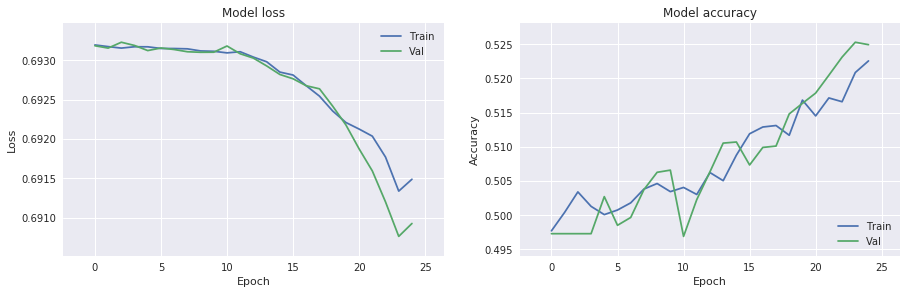

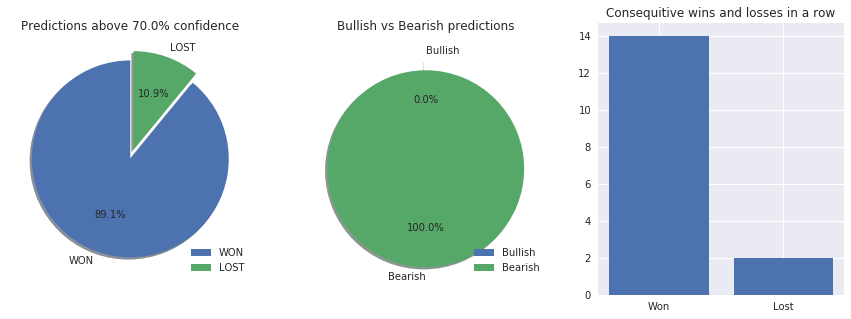

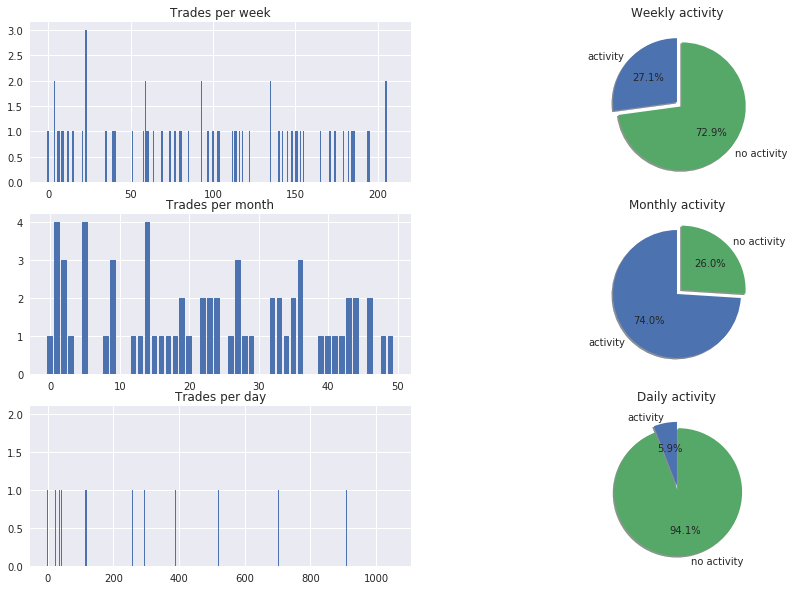

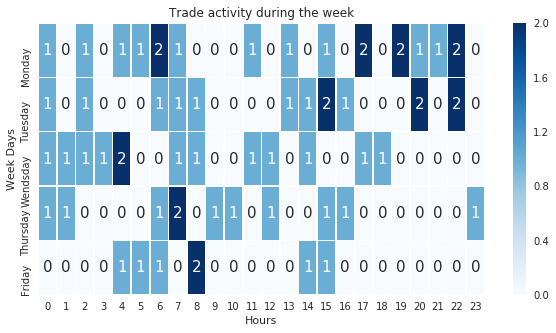

In [122]:
test=get_model_insights(model,history,0.3,X_test,Y_test,Y_dates_test)

##### We can now have a tool to clearly see insights of our trained model.

### Before finish of this chapter, Lets checck if we can get better results with Convolutional 1D netwok.

In [182]:
from keras.layers import Dense, Dropout, CuDNNLSTM, Conv1D,MaxPooling1D,Flatten
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(3, 4)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))


model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['acc'])

In [183]:
history=model.fit(X_train, Y_train,batch_size=500, epochs=10,validation_data=(X_val, Y_val))

Train on 50578 samples, validate on 25289 samples
Epoch 1/10
50578/50578 [==============================] - 3s 59us/step - loss: 1.7065 - acc: 0.4082 - val_loss: 0.3468 - val_acc: 0.4974
Epoch 2/10
50578/50578 [==============================] - 1s 16us/step - loss: 0.5164 - acc: 0.4739 - val_loss: 0.2713 - val_acc: 0.5077
Epoch 3/10
50578/50578 [==============================] - 1s 16us/step - loss: 0.3876 - acc: 0.4895 - val_loss: 0.2627 - val_acc: 0.5014
Epoch 4/10
50578/50578 [==============================] - 1s 16us/step - loss: 0.3405 - acc: 0.4940 - val_loss: 0.2584 - val_acc: 0.5027
Epoch 5/10
50578/50578 [==============================] - 1s 16us/step - loss: 0.3172 - acc: 0.4960 - val_loss: 0.2638 - val_acc: 0.5000
Epoch 6/10
50578/50578 [==============================] - 1s 16us/step - loss: 0.3005 - acc: 0.4964 - val_loss: 0.2551 - val_acc: 0.4963
Epoch 7/10
50578/50578 [==============================] - 1s 16us/step - loss: 0.2890 - acc: 0.4976 - val_loss: 0.2570 - val_acc

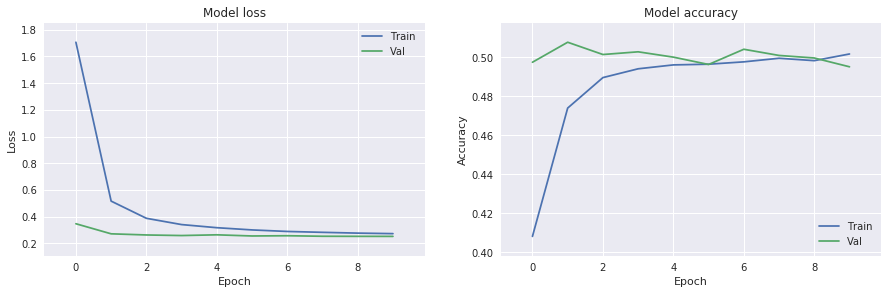

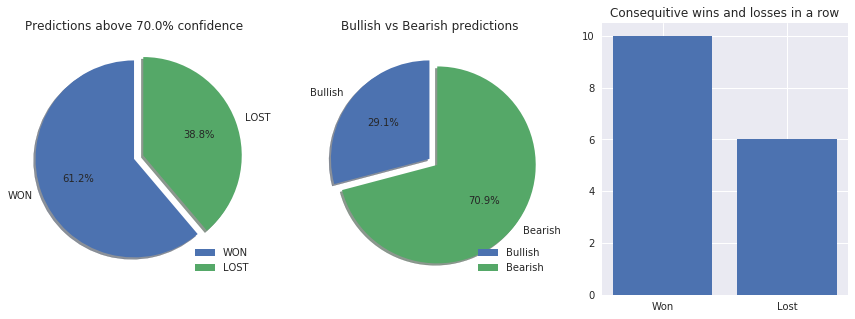

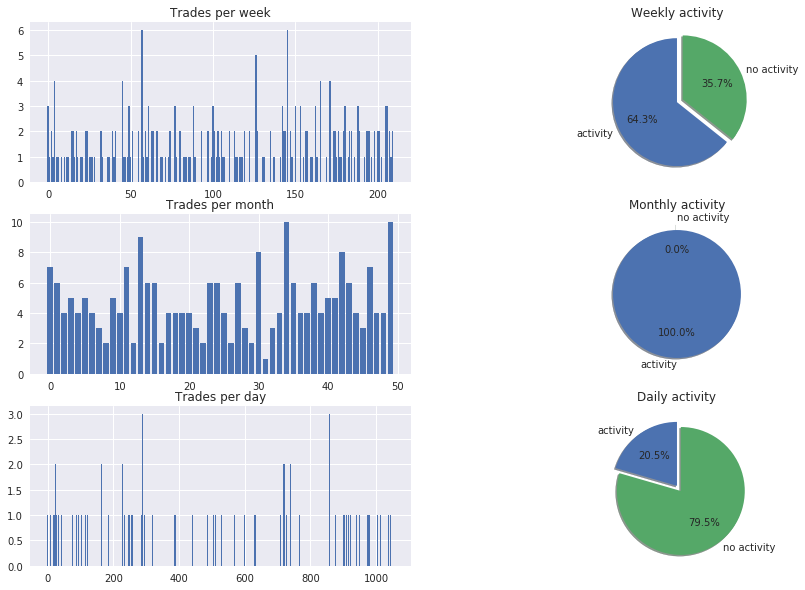

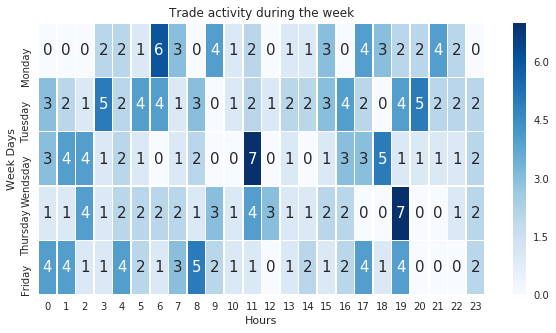

In [187]:
test=get_model_insights(model,history,0.3,X_test,Y_test,Y_dates_test)

#### The good news is that our model at least predict also the bullish candles.

In [234]:
EURUSD_dataset = pd.read_csv('Hour/EURUSD.csv')
del EURUSD_dataset['Volume']
X,Y, X_raw, Y_dates = my_generator_candle_X_Y(EURUSD_dataset.values,15,MinMax=True,Multi=True)

KeyboardInterrupt: 

In [ ]:
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X, Y, test_size=0.5)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

X_train_raw, X_val_and_test_raw,Y_dates_train,Y_dates_val_and_test= train_test_split(X_raw,Y_dates ,test_size=0.5)
X_val_raw, X_test_raw,Y_dates_val,Y_dates_test = train_test_split(X_val_and_test_raw,Y_dates_val_and_test, test_size=0.5)

In [311]:
from keras.layers import Dense, Dropout, CuDNNLSTM, Conv1D,MaxPooling1D,Flatten,Convolution1D,Activation
model = Sequential()
model.add(Convolution1D(input_shape = (15,4), 
                        nb_filter=64,
                        filter_length=2,
                        border_mode='valid',
                        activation='relu',
                        subsample_length=1))
model.add(MaxPooling1D(pool_length=2))

model.add(Convolution1D(input_shape = (15,4), 
                        nb_filter=64,
                        filter_length=2,
                        border_mode='valid',
                        activation='relu',
                        subsample_length=1))
model.add(MaxPooling1D(pool_length=2))

model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(250))
model.add(Dropout(0.25))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

#history = TrainingHistory()

model.compile(optimizer='adam', 
loss='binary_crossentropy', 
metrics=['accuracy'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(input_shape=(15, 4), activation="relu", filters=64, kernel_size=2, strides=1, padding="valid")`
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(input_shape=(15, 4), activation="relu", filters=64, kernel_size=2, strides=1, padding="valid")`
  app.launch_new_instance()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`


In [ ]:
history=model.fit(X_train, Y_train,batch_size=500, epochs=10,validation_data=(X_val, Y_val))

In [ ]:
test=get_model_insights(model,history,0.3,X_test,Y_test,Y_dates_test)

In [304]:
EURUSD_dataset = pd.read_csv('Hour/EURUSD.csv')
del EURUSD_dataset['Volume']
GBPUSD_dataset = pd.read_csv('Hour/GBPUSD.csv')
del GBPUSD_dataset['Volume']

In [310]:
train_gen=my_generator_candle_X_Y_CPU(EURUSD_dataset.values,15,500,return_more=False,MinMax=True,Multi=True)
val_gen=my_generator_candle_X_Y_CPU(GBPUSD_dataset.values,15,500,return_more=False,MinMax=True,Multi=True)

In [ ]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=200,
                              epochs=3,
                              validation_data=val_gen,
                              validation_steps=200)

Epoch 1/3
153/200 [=====================>........] - ETA: 18s - loss: 0.6939 - acc: 0.5017

In [307]:
AUDUSD_dataset = pd.read_csv('Hour/AUDUSD.csv').tail(20000)
del AUDUSD_dataset['Volume']
X,Y, X_raw, Y_dates = my_generator_candle_X_Y(AUDUSD_dataset.values,15,MinMax=True,Multi=True)

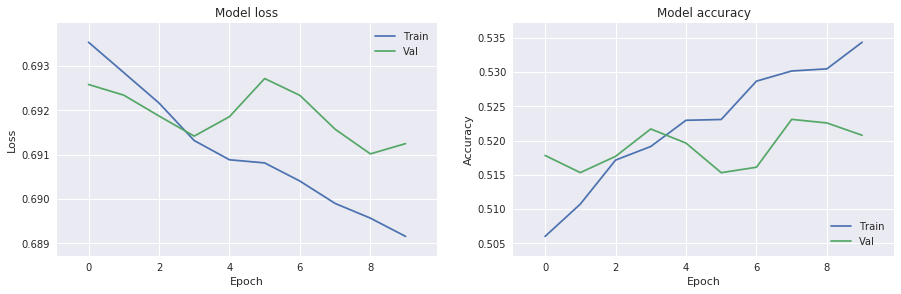

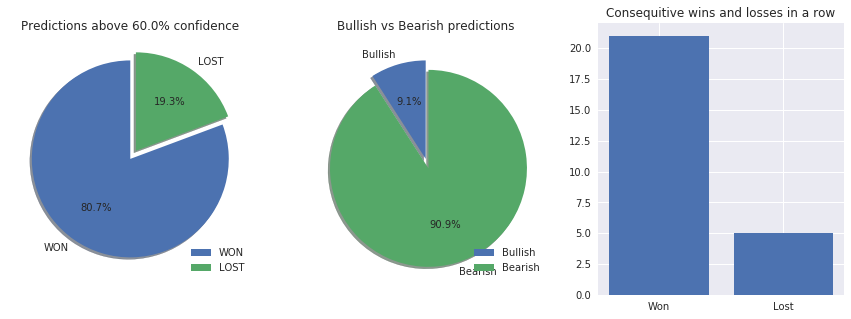

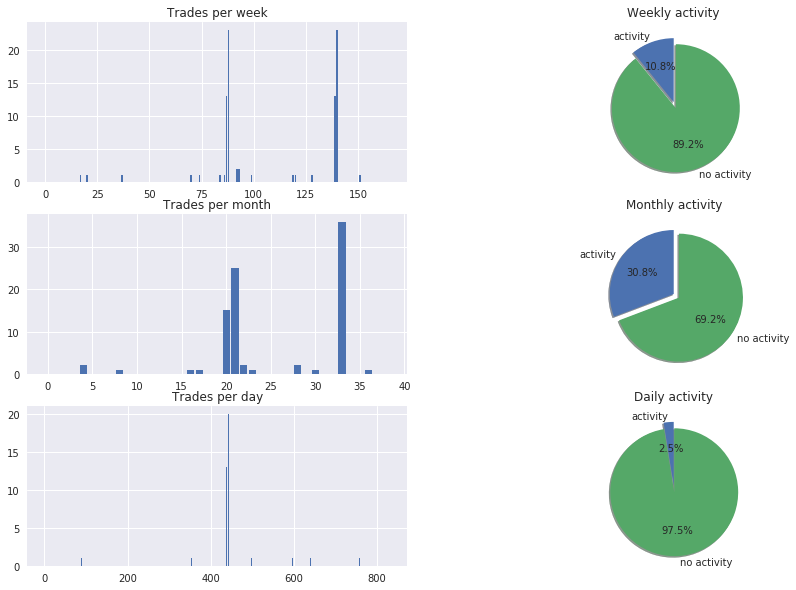

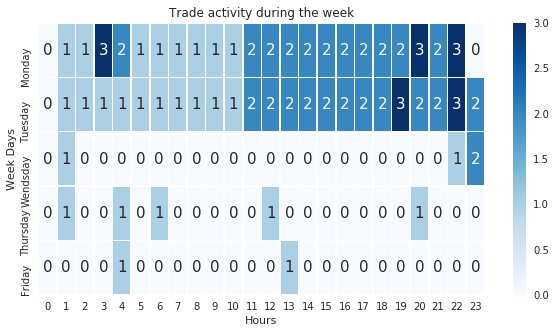

In [309]:
test=get_model_insights(model,history,0.4,X,Y,Y_dates)

In [299]:
def my_generator_candle_X_Y_CPU(data,lookback,batch_size,return_more=True,MinMax=False,Multi=False):
    
    if MinMax==True:scaler = preprocessing.MinMaxScaler()
    
    batch_rows = round(len(data)/batch_size,0)
    first_row = 0
    
    while 1:    

        arr = np.empty((0,lookback,4))
        arr3 = np.empty((0,lookback,5))
        Y_list = []
        Y_dates_list = []
        for a in range(int(batch_size)-lookback):
            temp_list = []
            temp_list_raw = []
            for candle in data[first_row:first_row+lookback]:
                converted_data = ohlc_to_candlestick(candle)
                temp_list.append(converted_data)
                temp_list_raw.append(candle)
            temp_list3 = [np.asarray(temp_list)]
            templist4 = np.asarray(temp_list3)

            if MinMax==True:
                templist99 = scaler.fit_transform(templist4[0])
                arr = np.append(arr, [templist99], axis=0)
            else:    
                arr = np.append(arr, templist4, axis=0)

            temp_list7 = [np.asarray(temp_list_raw)]
            templist8 = np.asarray(temp_list7)
            arr3 = np.append(arr3, templist8, axis=0)

            converted_data_prediction = ohlc_to_candlestick(data[first_row+lookback])
            Prediction = converted_data_prediction[0]
            if Multi==True:
                if Prediction== 1: Prediction=[1,0]
                if Prediction== 0: Prediction=[0,1]
                Y_list.append(np.asarray(Prediction))
            if Multi==False:  
                Y_list.append(Prediction)


            Y_dates_list.append(data[first_row+lookback][0])

            first_row=first_row+1
            if (len(data)-lookback-1)<=first_row:first_row=0
        arr2 = np.asarray(Y_list)
        arr4 = np.asarray(Y_dates_list)
        
        if return_more==True:
            yield  arr,arr2,arr3,arr4
        if return_more==False:
            yield  arr,arr2